In [1]:
import os
import numpy as np
import torch
from torch.utils import *
import torchvision
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
seed =1234
torch.manual_seed(seed)
np.random.seed(seed)

**visualization of the datset**

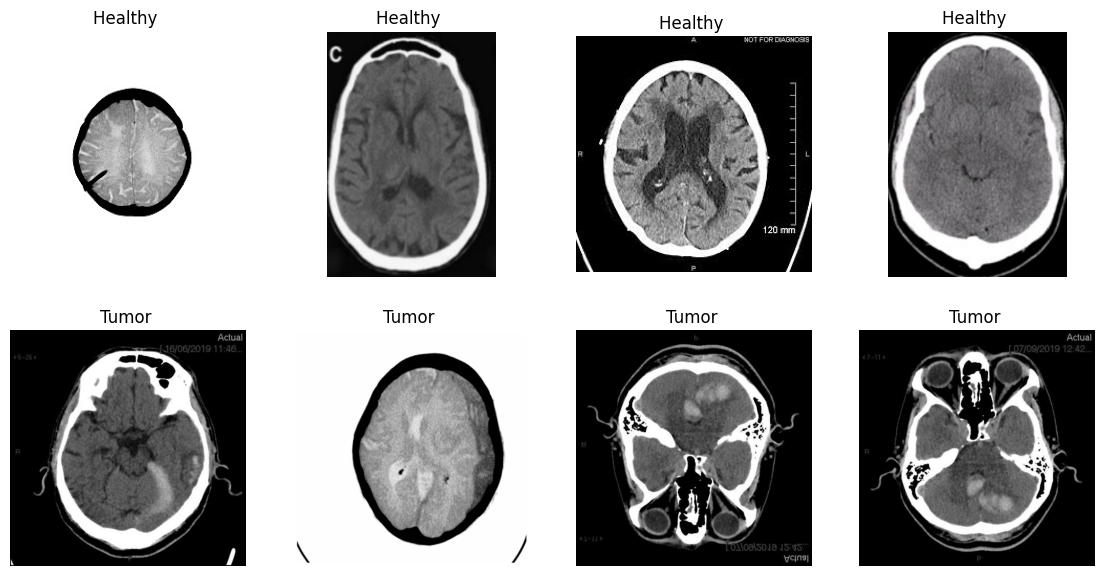

In [3]:
healthy_filenames = os.listdir(r"C:\Users\user\Desktop\ندقش\brain CT\Dataset\Brain Tumor CT scan Images\Healthy")
tumor_filenames = os.listdir(r"C:\Users\user\Desktop\ندقش\brain CT\Dataset\Brain Tumor CT scan Images\Tumor")


fig,ax = plt.subplots(2,4,figsize=(14,7))

axes = ax.flatten()
for i in range(8):
    healthy_filepath = os.path.join(r"C:\Users\user\Desktop\ندقش\brain CT\Dataset\Brain Tumor CT scan Images\Healthy",healthy_filenames[i])
    tumor_filthpath = os.path.join(r"C:\Users\user\Desktop\ندقش\brain CT\Dataset\Brain Tumor CT scan Images\Tumor",tumor_filenames[i])
    healthy_img = Image.open(healthy_filepath)
    tumor_img = Image.open(tumor_filthpath)
    if i < 4:
        axes[i].imshow(healthy_img, cmap="Greys")
        axes[i].set_title(f"Healthy ")
        axes[i].axis('off')

    else:
        axes[i] .imshow(tumor_img, cmap="Greys")
        axes[i].set_title(f"Tumor ")
        axes[i].axis('off') 


        

In [4]:
print(f"tumor samples :{len(tumor_filenames)}")
print(f"healthy samples :{len(healthy_filenames)}")

tumor samples :2318
healthy samples :2300


**samples augmentation**

In [5]:
from torch.utils.data import Dataset,random_split, DataLoader
transformer = torchvision.transforms.Compose([
    torchvision.transforms.PILToTensor(),
    torchvision.transforms.ConvertImageDtype(torch.float),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),
    torchvision.transforms.Resize((64,64)),
    torchvision.transforms.RandomRotation(degrees=45),
    torchvision.transforms.RandomHorizontalFlip(p=0.6),
    torchvision.transforms.RandomVerticalFlip(p=0.6)]
)


# loading Dataset
dataset = torchvision.datasets.ImageFolder(r"C:\Users\user\Desktop\ندقش\brain CT\Dataset\Brain Tumor CT scan Images",transformer)

#Data split
train_size = int(0.70 * len(dataset))
test_size = int(0.15 * len(dataset))
valid_size =  len(dataset) - train_size - test_size
train_dataset,test_dataset,valid_dataset = random_split(dataset,[train_size,test_size,valid_size])


print((f"{len(train_dataset)} training samples"))
print(f"{len(test_dataset)} test samples")
print(f"{len(valid_dataset)} validation samples")





3232 training samples
692 test samples
694 validation samples


In [6]:
#loaders
train_loader = DataLoader(train_dataset ,batch_size = 16,shuffle = True)
test_loader = DataLoader(test_dataset,batch_size=16,shuffle=False)
valid_loader = DataLoader(valid_dataset,batch_size=1,shuffle=False)
for idx, (x,y) in enumerate(train_loader):
    print(x.size())
    print(y.size())
    break

torch.Size([16, 3, 64, 64])
torch.Size([16])


In [15]:
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn as nn
w =  ResNet50_Weights.DEFAULT
resnet = resnet50(w)
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 2)

C:\Users\user\anaconda3\envs\computervision\Lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


**Model Training and Validation**

In [17]:
#training and validation loop
#from tqdm import tqdm
import  torch.optim as optim
torch.manual_seed(123)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = resnet.to(device)



num_epochs = 3

train_loss = []
test_loss = []

print(f"Training and testing the model")
loss_fn = nn.CrossEntropyLoss(torch.tensor([0.4,0.6])).to(device)
optimizer = optim.Adam(model.parameters())

for epoch in range(num_epochs):
  model.train()
  epoch_train_loss = 0
  num_batches = len(train_loader)
  for x, y in train_loader:
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    y_hat = model(x)
    loss = loss_fn(y_hat, y)
    epoch_train_loss += loss.item()
    loss.backward()
    optimizer.step()
  train_loss.append(epoch_train_loss / num_batches)
  print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_loss[-1]:.5f}")


  model.eval()
  epoch_test_loss = 0
  num_batches = len(test_loader)
  with torch.no_grad():
     for x, y in test_loader:
      x, y = x.to(device), y.to(device)
      y_hat = model(x)
      loss = loss_fn(y_hat, y)
      epoch_test_loss += loss.item()
  test_loss.append(epoch_test_loss / num_batches)
  print(f"Epoch {epoch + 1}/{num_epochs}, Test Loss: {test_loss[-1]:.5f}")






cpu
Training and testing the model
Epoch 1/3, Training Loss: 0.36435
Epoch 1/3, Test Loss: 0.21395
Epoch 2/3, Training Loss: 0.23615
Epoch 2/3, Test Loss: 0.14538
Epoch 3/3, Training Loss: 0.19025
Epoch 3/3, Test Loss: 0.13204


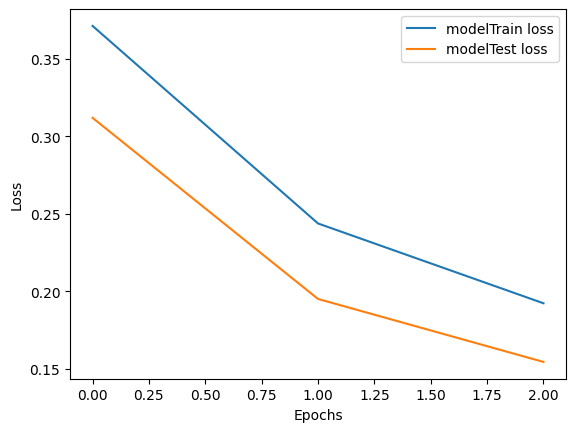

In [11]:

plt.plot(train_loss,label=f"modelTrain loss")
plt.plot(test_loss,label=f"modelTest loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

**confusion matrix**

In [18]:
#validation
import torch.nn.functional as F
y_true =[]
y_pred = []
model = model.to(device)
model.eval()
for i ,(x,y) in enumerate(valid_loader):
  y_true.append(torch.Tensor.numpy(y))
  epoch_loss = 0
  num_batches = len(valid_loader)
  with torch.no_grad():
    x = x.to(device)
    y = y.to(device)
    y_hat = model(x)
    y_probs  = F.softmax(y_hat,dim=1)
    y_hat = torch.argmax(y_hat)
    y_hat = torch.Tensor.cpu(y_hat)
    y_pred.append(torch.Tensor.numpy(y_hat))
    loss = loss_fn(y_probs,y)
    epoch_loss +=loss.item()
print(f"validation loss of the model: {epoch_loss/num_batches:.5f}")




validation loss of the model: 0.00046


model accuaracy score:0.9495677233429395
model precision score0.9748427672955975


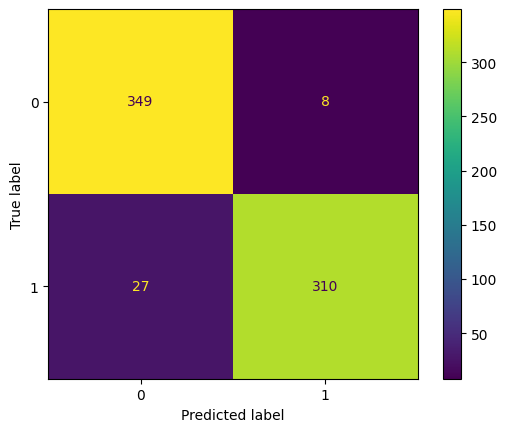

In [19]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score


y_pred = np.array(y_pred)
y_true = np.array(y_true)
y_pred = np.reshape(y_pred,(694))
y_true= np.reshape(y_true,(694))


cm = confusion_matrix(y_true,y_pred)

pr = precision_score(y_true,y_pred)
acc = accuracy_score(y_true,y_pred)

 
print(f"model accuaracy score:{acc}")
print(f"model precision score{pr}") 
d = ConfusionMatrixDisplay(confusion_matrix=cm)
d.plot()

Saving Model 1

In [20]:
torch.save(resnet,r"C:\Users\user\Desktop\ندقش\brain CT\Models\resnet.pth")
torch.save(resnet.state_dict(),r"C:\Users\user\Desktop\ندقش\brain CT\Models\resnet_weights.pth")